# Muon track analysis

This is the analysis of Geant4 data on muon tracks. The goal is to gain a preliminairy understanding of what signals a muon track leaves inside the optical module. This can be set in contrast to analyses utilizing data from homogenous illumination.

### imports

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

### Preperation

we need to hand over the PMT positions for the analysis:

In [40]:
# PMT position dict containing the angles for each PMT
pmt_positions = {
    0:  (     0,     25),
    1:  (    90,     25),
    2:  (   180,     25),
    3:  ( -  90,     25),
    4:  (    45,   57.5),
    5:  (   135,   57.5),
    6:  ( - 135,   57.5),
    7:  ( -  45,   57.5),
    8:  (    90, -   25),
    9:  (     0, -   25),
    10: ( -  90, -   25),
    11: (   180, -   25),
    12: (    45, - 57.5),
    13: ( -  45, - 57.5),
    14: ( - 135, - 57.5),
    15: (   135, - 57.5),
}

as well as information on the simulated muon track in cartesian coordinates:

In [41]:
mu_start = (5000,  -50000, 5000)
mu_end   = (5000,   50000, 5000)
mu_E     = 1 # TeV

Now lets get the full muon track in cartesian and polar coordinates

In [42]:
# get muon track in cartesian coordinates
num_points = 10000
mu_x_vals = np.linspace(mu_start[0], mu_end[0], num_points)
mu_y_vals = np.linspace(mu_start[1], mu_end[1], num_points)
mu_z_vals = np.linspace(mu_start[2], mu_end[2], num_points)

# convert to polar
mu_r     = np.sqrt(mu_x_vals**2 + mu_y_vals**2 + mu_z_vals**2)
mu_theta = np.pi/2 - np.arccos(mu_z_vals/mu_r)
mu_phi   = np.arctan2(mu_y_vals, mu_x_vals)

Now we import the datafile

In [43]:
datafile = "/home/nretza/ECP_libraries/Geant4-Simulations/P-OM/data/out_mu.csv"
df = pd.read_csv(datafile)

and subtract the width of the flange for the later analysis

In [44]:
flange_thickness = 90 # mm
df['g_z'] = df['g_z'] - flange_thickness/2 * np.sign(df["g_z"])

we need some subsets of the data for the later analysis:

In [45]:
df_photons  = df.query("PID == -22")
df_glass    = df_photons.query("g_x != 0 and g_y != 0 and g_z != 0")
df_detected = df_glass.query("out_ProcessName == 'OpAbsorption' and out_VolumeName.str.contains('photocathode')")

Now we need t think about hat we actually want and convert points into polar coordinates to plot on a 2D projection:
* we want the initial positions of photons that touch the glass to lay them over the muon track
* we want the glass contact points of detected photons.
* the detection points of the photons as sanity check.
* we want a histogram tracking the hits per PMT to also put that into the plot.

In [46]:
# initial positions
photons_in_r     = np.sqrt(df_glass['in_x']**2 + df_glass['in_y']**2 + df_glass['in_z']**2)
photons_in_theta = np.pi/2 - np.arccos(df_glass['in_z']/photons_in_r) 
photons_in_phi   = np.arctan2(df_glass['in_y'], df_glass['in_x'])

# initial positions
photons_in_d_r     = np.sqrt(df_detected['in_x']**2 + df_detected['in_y']**2 + df_detected['in_z']**2)
photons_in_d_theta = np.pi/2 - np.arccos(df_detected['in_z']/photons_in_d_r) 
photons_in_d_phi   = np.arctan2(df_detected['in_y'], df_detected['in_x'])

# glass contact points
photons_g_r     = np.sqrt(df_detected['g_x']**2 + df_detected['g_y']**2 + (df_detected['g_z'])**2)
photons_g_theta = np.pi/2 - np.arccos((df_detected['g_z'])/photons_g_r)
photons_g_phi   = np.arctan2(df_detected['g_y'], df_detected['g_x'])

# glass contact points
photons_out_r     = np.sqrt(df_detected['out_x']**2 + df_detected['out_y']**2 + (df_detected['out_z'])**2)
photons_out_theta = np.pi/2 - np.arccos((df_detected['out_z'])/photons_g_r)
photons_out_phi   = np.arctan2(df_detected['out_y'], df_detected['out_x'])

# detection histogram
pmt_hits, pmt_hit_bins = np.histogram(df_detected['out_Volume_CopyNo'], bins=range(len(pmt_positions) + 1))

/home/nretza/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [47]:
print(len(photons_out_r))

1035


### Signals from the track

now lets overlay everything in a plot:

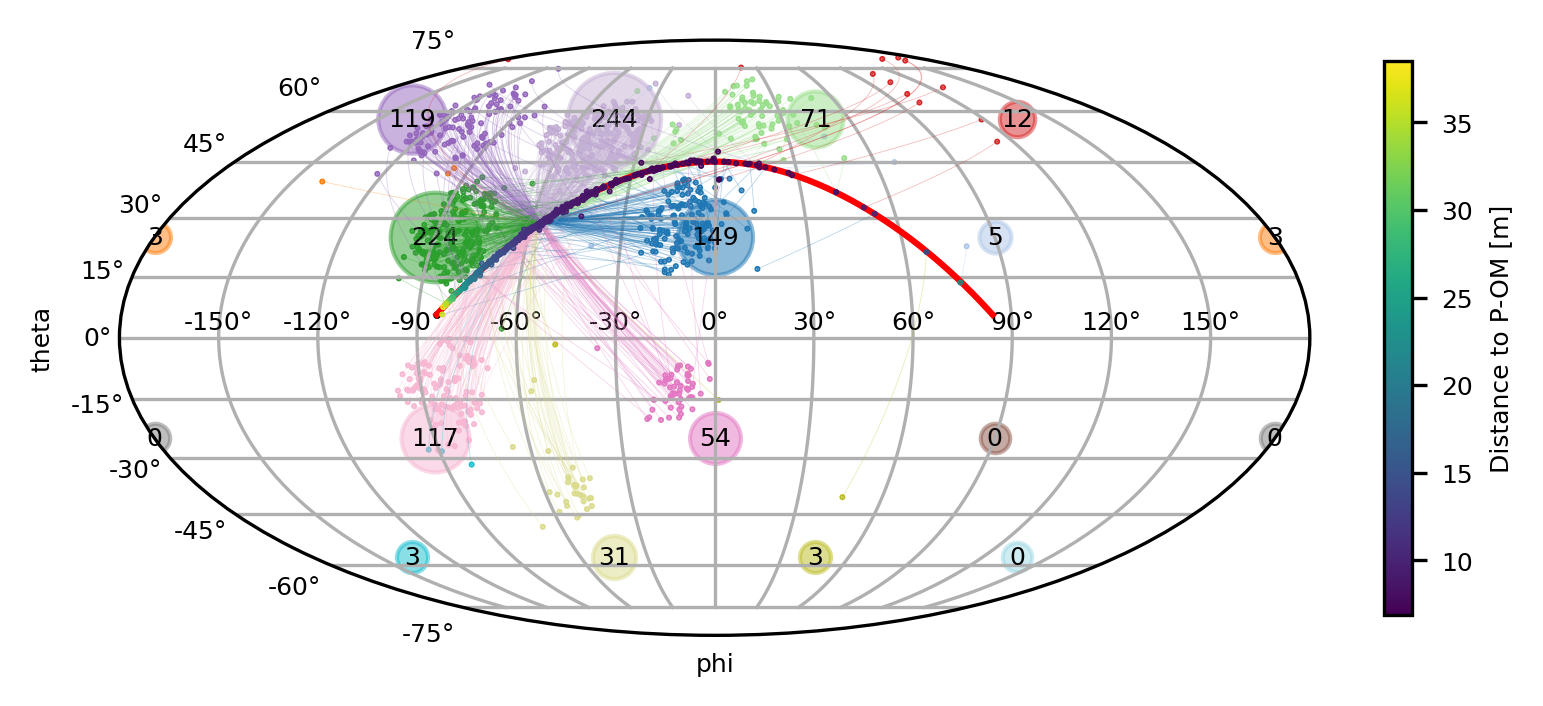

In [51]:
# plot settings
dpi        = 300
font_size  = 6
s_min      = 50
s_max      = 500
alpha      = 0.5

plt.rcParams['figure.dpi']  = dpi
plt.rcParams['savefig.dpi'] = dpi

plt.figure()
plt.subplot(projection="mollweide")
plt.grid(True)
plt.xlabel("phi", fontsize = font_size)
plt.ylabel("theta", fontsize = font_size)
plt.xticks(fontsize=font_size) 
plt.yticks(fontsize=font_size)

# pmt colors
pmt_colors = plt.cm.tab20(np.linspace(0, 1, 16))

# scatter plot for glass contact points
plt.scatter(photons_g_phi, photons_g_theta, s=0.2, c=pmt_colors[df_detected['out_Volume_CopyNo']], cmap='viridis')

# Plot circles for each PMT
for i, pos in pmt_positions.items():
    x = np.deg2rad(pos[0])
    y = np.deg2rad(pos[1])
    size = (s_max - s_min) * pmt_hits[i] / max(pmt_hits) + s_min
    color = pmt_colors[i]
    plt.scatter(x, y, s=size, color=color, alpha=alpha)
    plt.annotate(f"{pmt_hits[i]}", xy=(x, y), ha='center', va='center', size=font_size)
    if x == np.pi:
        plt.scatter(-np.pi, y, s=size, color=color, alpha=alpha)
        plt.annotate(f"{pmt_hits[i]}", xy=(-np.pi, y), ha='center', va='center', size=font_size)

for x1, y1, x2, y2, c in zip(photons_in_d_phi, photons_in_d_theta, photons_g_phi, photons_g_theta, pmt_colors[df_detected['out_Volume_CopyNo']]):
    plt.plot([x1, x2], [y1, y2], color=c, linewidth=0.2, alpha=0.3, zorder=5)

# muon track
plt.plot(mu_phi, mu_theta, color='red', label="muon track", zorder=10)

# scatter plot for initial photon positions
plt.scatter(photons_in_d_phi, photons_in_d_theta, c=(photons_in_d_r/1000), s=0.2, cmap='viridis', zorder=20)
cbar = plt.colorbar(shrink=0.5)
cbar.ax.tick_params(labelsize=font_size)
cbar.ax.set_ylabel('Distance to P-OM [m]', size=font_size);